## This notebook is for deep learning classification of sentiment analysis and impact analysis

In [1]:
## deep learning 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import nltk
import string
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

In [2]:
## import data
df = pd.read_csv('./data/final_annotations_duplicatesTagged_modTBDs - final_annotations_duplicatesTagged.csv')

In [3]:
df.drop(['sentence', 'sentiments','impacts', 'film_title', 'batch'], axis = 1, inplace = True) ## drop columns that are not needed
df = df[df['duplicated'] != True] # remove duplicates 
df = df[df['impact'] != 'TBD'] # remove TBDs
df.drop(['duplicated'], axis = 1, inplace = True) # drop duplicated column

In [4]:
df.columns

Index(['sentiment', 'impact', 'sentences_nopunc'], dtype='object')

In [66]:
import pandas as pd
import numpy as np
import gensim
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA

# Define a function to preprocess text
def preprocess_text(text):
    # Remove any non-alphanumeric characters
    text = re.sub(r'\W+', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize the text into individual words
    words = text.split()
    # Remove stop words
    words = [word for word in words if word not in stopwords.words('english')]
    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # Join the words back into a single string
    text = ' '.join(words)
    return text

# Preprocess the text in your dataframe
df['preprocessed_text'] = df['sentences_nopunc'].apply(preprocess_text)

# Split the preprocessed text into individual sentences
sentences = [text.split() for text in df['preprocessed_text']]

# Train a Word2Vec model on your data
model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)

# Transform each sentence into a vector using the Word2Vec model
vectors = np.array([np.mean([model.wv.get_vector(word) for word in sentence if word in model.wv.index_to_key], axis=0) 
                    if any(word in model.wv.index_to_key for word in sentence) else np.zeros(model.vector_size) 
                    for sentence in sentences])


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(vectors, df['impact'], test_size=0.2, random_state=42)

In [67]:
X_train_sent, X_test_sent, y_train_sent, y_test_sent = train_test_split(vectors, df['sentiment'], test_size=0.2, random_state=42)

In [68]:
y_train_sent = pd.get_dummies(y_train_sent)
y_test_sent = pd.get_dummies(y_test_sent)

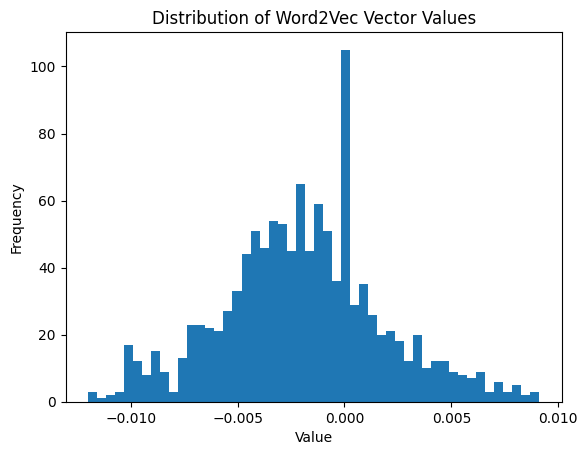

In [69]:
vector_dim = 0
vector_values = [vector[vector_dim] for vector in vectors]

# Create a histogram of the vector values
plt.hist(vector_values, bins=50)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Word2Vec Vector Values')
plt.show()

In [70]:
from sklearn.cluster import KMeans

# Set the number of clusters
num_clusters = 5

# Fit KMeans clustering model to the vectors
kmeans_model = KMeans(n_clusters=num_clusters)
kmeans_model.fit(vectors)

# Get the cluster labels for each vector
cluster_labels = kmeans_model.predict(vectors)

# Create a dictionary to map each vector to its corresponding sentence
vector_to_sentence = {tuple(v): s for v, s in zip(vectors, sentences)}

# Create a dictionary to store the words in each cluster
cluster_to_words = {i: [] for i in range(num_clusters)}

# Populate the cluster_to_words dictionary with the words in each cluster
for vector, label in zip(vectors, cluster_labels):
    sentence = vector_to_sentence[tuple(vector)]
    cluster_to_words[label].extend(sentence)

# Print out the words in each cluster
for cluster, words in cluster_to_words.items():
    print(f"Cluster {cluster}: {', '.join(set(words))}")


Cluster 0: didnt, twister, otherwise, solid, day, asleep, 6, minute, past, difference, fall, pay, interesting, enjoyable, watch, need, coulkd, found, 7, great, dont, rainy, mean, 4
Cluster 1: breathless, young, excited, magnitude, storyline, treatise, world, zombie, confused, mustwatch, lizard, matter, really, indepth, cut, polar, expect, window, shortcoming, verified, tornadochasers, he, feel, lovely, script, story, aftermath, ahead, comprehend, galaxy, anatomy, actively, demonstrate, emerge, sectioning, player, caused, experience, mr, expanded, significant, anyone, wondering, profile, developed, achieve, related, failure, survival, quality, considering, sad, gain, swirl, cmes, sounding, sort, demo, placing, fails, theyve, voicing, 60, hardly, brings, wont, dull, junk, disjointed, entertainment, middle, taking, house, enjoyable, curiosity, come, ill, bobbing, boggles, alarming, 1859, fittingly, responder, deliver, writing, ready, cost, physical, white, grocery, write, western, dragon,

/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


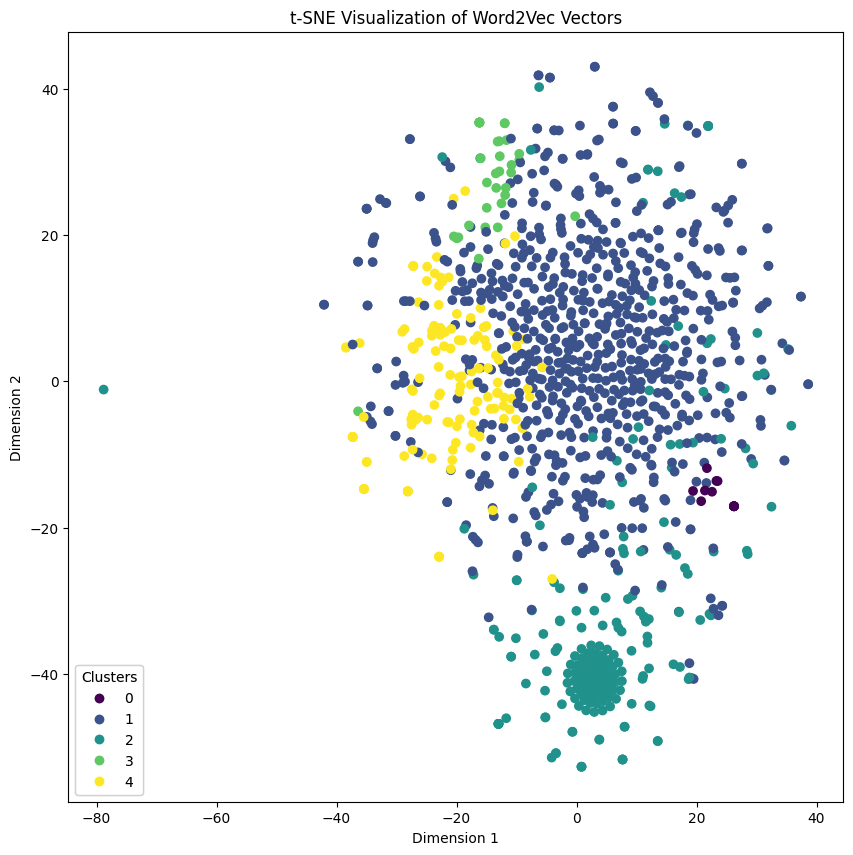

In [71]:
## visualizing the clusters
from sklearn.manifold import TSNE

# Reduce the vectors to 2 dimensions using t-SNE
vectors_2d = TSNE(n_components=2, init='pca', learning_rate='auto').fit_transform(vectors)

# Create a scatter plot of the 2D vectors
plt.figure(figsize=(10, 10))
scatter = plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c=cluster_labels)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE Visualization of Word2Vec Vectors')
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="lower left", title="Clusters")
plt.gca().add_artist(legend1)
plt.show()

In [72]:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [73]:
print("input shape: ", X_train.shape)
print("output shape: ", y_train.shape)

input shape:  (927, 100)
output shape:  (927, 5)


In [74]:
## saving X_train, X_test, y_train, y_test
np.save('./data/X_train.npy', X_train)
np.save('./data/X_test.npy', X_test)
np.save('./data/y_train.npy', y_train)
np.save('./data/y_test.npy', y_test)

In [75]:
from keras.layers import Embedding
embedding_layer = Embedding(1000, 64)

In [76]:
!pip3 install pydot


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [77]:
y_train_sent

,Negative,Neutral,Positive
58,1,0,0
339,0,0,1
338,0,0,1
1161,0,1,0
63,1,0,0
...,...,...,...
1140,1,0,0
1191,0,0,1
1226,0,0,1
939,1,0,0


In [78]:

from keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D
from keras.models import Model
from keras.layers import LayerNormalization
from keras.layers import MultiHeadAttention
## import regularizers
import tensorflow as tf

# Define the input layer
inputs = Input(shape=(X_train.shape[1],))
embedding_layer = Embedding(1000, 64)(inputs)
embed_layer = Dropout(rate=0.5)(embedding_layer)
for i in range(2):
    # Multi-Head Attention
    transformer_block = MultiHeadAttention(num_heads=8, key_dim=64)(embed_layer, embed_layer)
    transformer_block = Dropout(rate=0.5)(transformer_block)
    transformer_block = LayerNormalization(epsilon=1e-6)(transformer_block)
    # Feed Forward Network
    transformer_block = Dense(64, activation="relu", bias_regularizer= tf.keras.regularizers.l2(0.01))(transformer_block)
    transformer_block = Dropout(rate=0.5)(transformer_block)
    transformer_block = LayerNormalization(epsilon=1e-6)(transformer_block)
    embed_layer = transformer_block
transformer_block = GlobalAveragePooling1D()(transformer_block)
transformer_block = Dense(32, activation="relu")(transformer_block)
transformer_block = Dropout(rate=0.5)(transformer_block)
outputs = Dense(5, activation="softmax")(transformer_block)
model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_9 (Embedding)        (None, 100, 64)      64000       ['input_4[0][0]']                
                                                                                                  
 dropout_21 (Dropout)           (None, 100, 64)      0           ['embedding_9[0][0]']            
                                                                                                  
 multi_head_attention_6 (MultiH  (None, 100, 64)     132672      ['dropout_21[0][0]',             
 eadAttention)                                                    'dropout_21[0][0]']       

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
4/4 [==============================] - 5s 917ms/step - loss: 1.3720 - accuracy: 0.4854 - val_loss: 1.3523 - val_accuracy: 0.6509
Epoch 2/100
4/4 [==============================] - 3s 793ms/step - loss: 1.2780 - accuracy: 0.5653 - val_loss: 1.3386 - val_accuracy: 0.6509
Epoch 3/100
4/4 [==============================] - 3s 794ms/step - loss: 1.2469 - accuracy: 0.5739 - val_loss: 1.3733 - val_accuracy: 0.6509
Epoch 4/100
4/4 [==============================] - 3s 792ms/step - loss: 1.2412 - accuracy: 0.5890 - val_loss: 1.3342 - val_accuracy: 0.6509
Epoch 5/100
4/4 [==============================] - 3s 785ms/step - loss: 1.2248 - accuracy: 0.6030 - val_loss: 1.3724 - val_accuracy: 0.6509
Epoch 6/100
4/4 [==============================] - 3s 777ms/step - loss: 1.2351 - accuracy: 0.6052 - val_loss: 1.3280 - val_accuracy: 0.6509
Epoch

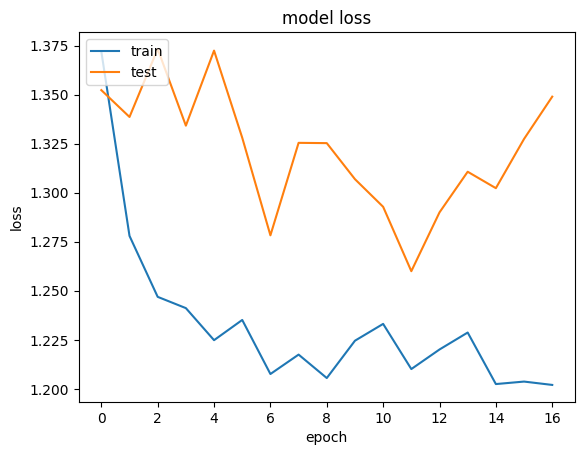

In [79]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

from keras.callbacks import Callback
from keras.callbacks import EarlyStopping

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

history = LossHistory()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

## training the model
model.fit(X_train, y_train, epochs=100, batch_size=256, validation_data=(X_test, y_test), callbacks=[history, early_stopping])

## plotting the loss as the model trains
plt.plot(history.losses)
plt.plot(history.val_losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [95]:
## evaluating the model
score = model.evaluate(X_train, y_train, batch_size=256)
print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

4/4 [==============================] - 2s 375ms/step - loss: 1.4427 - accuracy: 0.6117
Test loss:  1.4427329301834106
Test accuracy:  0.6116504669189453


In [51]:
df.head()

,sentiment,impact,sentences_nopunc
0,Negative,Engagement with Film,a few spots were boring
1,Negative,Engagement with Film,we landed probes on mars and orbited celestial...
2,Negative,Engagement with Film,very dry and unimaginative
3,Negative,Engagement with Film,it seemed a bit repetitive
4,Negative,Engagement with Film,i didnt watch it past 4 minutes


In [52]:
from transformers import BertTokenizer, TFBertModel, BertConfig, TFBertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [53]:
print(' Original: ', df['sentences_nopunc'][0])

 Original:  a few spots were boring


In [54]:
print("Tokenized: ", tokenizer.tokenize(df['sentences_nopunc'][0]))

Tokenized:  ['a', 'few', 'spots', 'were', 'boring']


In [55]:
print("Token IDs: ", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(df['sentences_nopunc'][0])))

Token IDs:  [1037, 2261, 7516, 2020, 11771]


In [56]:
max_len = 0
for sent in df['sentences_nopunc']:
    max_len = max(max_len, len(tokenizer.tokenize(sent)))

print('Max sentence length: ', max_len)

Max sentence length:  65


In [57]:
def mask_inputs(sents, max_len):
    input_ids = []
    attention_masks = []
    i = 0
    for sent in sents:
        encoded_dict = tokenizer.encode_plus(
            sent,
            add_special_tokens=True,
            max_length=max_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='tf',
            truncation=True,
            padding='max_length'
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
        i += 1
        if i % 1000 == 0:
            print(i)
    return np.array(input_ids), np.array(attention_masks)

In [58]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['sentences_nopunc'], df['sentiment'], test_size=0.2, random_state=42)

X_train, train_masks = mask_inputs(X_train, max_len)
X_test, test_masks = mask_inputs(X_test, max_len)
Y_train = tf.convert_to_tensor(y_train)
Y_test = tf.convert_to_tensor(y_test)

In [59]:
print("input shape: ", X_train.shape)
print("output shape: ", Y_train.shape)

input shape:  (927, 1, 65)
output shape:  (927,)


In [61]:
Y_train[0]

<tf.Tensor: shape=(), dtype=string, numpy=b'Negative'>

In [37]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2])

In [47]:
bert_model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1, )

bert_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
bert_model.summary()

Model: "tf_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_156 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
Total params: 109,483,009
Trainable params: 109,483,009
Non-trainable params: 0
_________________________________________________________________


In [49]:
print("input shape: ", X_train.shape)
print("output shape: ", Y_train.shape)
print("X_test shape: ", X_test.shape)
print("Y_test shape: ", Y_test.shape)

input shape:  (927, 65)
output shape:  (927, 3)
X_test shape:  (232, 65)
Y_test shape:  (232, 3)


In [50]:
history = bert_model.fit(X_train, y_train, epochs=10, validation_data=(X_test,y_test))

Epoch 1/10


2023-03-25 10:56:33.149918: W tensorflow/core/framework/op_kernel.cc:1757] OP_REQUIRES failed at cast_op.cc:121 : UNIMPLEMENTED: Cast string to float is not supported


UnimplementedError: Graph execution error:

Detected at node 'categorical_crossentropy/Cast' defined at (most recent call last):
    File "/opt/homebrew/Cellar/python@3.10/3.10.9/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Cellar/python@3.10/3.10.9/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/rishabhsharma/Library/Python/3.10/lib/python/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/rishabhsharma/Library/Python/3.10/lib/python/site-packages/traitlets/config/application.py", line 978, in launch_instance
      app.start()
    File "/Users/rishabhsharma/Library/Python/3.10/lib/python/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/Users/rishabhsharma/Library/Python/3.10/lib/python/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Cellar/python@3.10/3.10.9/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/opt/homebrew/Cellar/python@3.10/3.10.9/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/base_events.py", line 1906, in _run_once
      handle._run()
    File "/opt/homebrew/Cellar/python@3.10/3.10.9/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/rishabhsharma/Library/Python/3.10/lib/python/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/Users/rishabhsharma/Library/Python/3.10/lib/python/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/Users/rishabhsharma/Library/Python/3.10/lib/python/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/Users/rishabhsharma/Library/Python/3.10/lib/python/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/Users/rishabhsharma/Library/Python/3.10/lib/python/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/Users/rishabhsharma/Library/Python/3.10/lib/python/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/rishabhsharma/Library/Python/3.10/lib/python/site-packages/IPython/core/interactiveshell.py", line 2885, in run_cell
      result = self._run_cell(
    File "/Users/rishabhsharma/Library/Python/3.10/lib/python/site-packages/IPython/core/interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "/Users/rishabhsharma/Library/Python/3.10/lib/python/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/rishabhsharma/Library/Python/3.10/lib/python/site-packages/IPython/core/interactiveshell.py", line 3139, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/rishabhsharma/Library/Python/3.10/lib/python/site-packages/IPython/core/interactiveshell.py", line 3318, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/rishabhsharma/Library/Python/3.10/lib/python/site-packages/IPython/core/interactiveshell.py", line 3378, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/fj/r2kb_f4d3k1gxmcwsdc81_1r0000gn/T/ipykernel_80389/3204691496.py", line 1, in <module>
      history = bert_model.fit(X_train, y_train, epochs=10, validation_data=(X_test,y_test))
    File "/opt/homebrew/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/lib/python3.10/site-packages/keras/engine/training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/lib/python3.10/site-packages/keras/engine/training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/lib/python3.10/site-packages/keras/engine/training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/lib/python3.10/site-packages/keras/engine/training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 1569, in train_step
      loss = self.compiled_loss(y, y_pred, sample_weight, regularization_losses=self.losses)
    File "/opt/homebrew/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/opt/homebrew/lib/python3.10/site-packages/keras/losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "/opt/homebrew/lib/python3.10/site-packages/keras/losses.py", line 272, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/opt/homebrew/lib/python3.10/site-packages/keras/losses.py", line 1977, in categorical_crossentropy
      y_true = tf.cast(y_true, y_pred.dtype)
Node: 'categorical_crossentropy/Cast'
Cast string to float is not supported
	 [[{{node categorical_crossentropy/Cast}}]] [Op:__inference_train_function_99539]